In [1]:
import os
from pathlib import Path
import sys

sys.path.insert(0, str(Path(os.getcwd()).parent.parent))

from typing import Union
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch

from src.data_analysis.fully_connected_network import ACAIGFCN
from src.data_analysis.custom_cnn import MyFirstCNN, MySecondCNN
from src.data_analysis.mnist_constants import FASHION_MNIST_INPUT_DIM, FASHION_MNIST_OUTPUT_DIM
from src.common.file_io_helper import incriment_file

MODEL_EXPERIMENT_FILEPATH = 'experiments/models/experiment_number_{:04d}.pth'

In [2]:
experiment_filepath = 'experiments/experiments.json'

with open(experiment_filepath, 'r') as file:
    records = json.load(file)
    experiment_results_df = pd.DataFrame.from_records(records)

experiment_results_df.tail()

,model_type,num_epochs,total_num_weights,training_time,optimizer,learning_rate,optimizer_hyperparams,weight_init,mean_test_accuracy,std_test_accuracy
40,CNN,30,54890,0:02:40,SGD,0.100,{'momentum': 0.9},xavier_uniform,0.907617,0.017698
41,CNN,30,54890,0:02:43,Adam,0.100,"{'betas': [0.9, 0.99]}",xavier_uniform,0.892480,0.020222
42,CNN,30,54890,0:02:41,RMSprop,0.100,{'alpha': 0.9},xavier_uniform,0.829004,0.019870
43,CNN,40,54890,0:03:40,Adam,0.001,"{'betas': [0.9, 0.999]}",kaiming_uniform,0.917285,0.016867
44,CNN,40,54890,0:03:39,Adam,0.001,"{'betas': [0.9, 0.999]}",kaiming_uniform,0.916992,0.016147


In [3]:
# Mean test accuracy for the 5 trials of the best model
# best_model_trials = [356, 357, 358, 359, 360]
# experiment_results_df.iloc[best_model_trials].mean_test_accuracy.describe()

In [4]:
experiment_results_df.loc[experiment_results_df["mean_test_accuracy"].idxmax()]

model_type                                   CNN
num_epochs                                    40
total_num_weights                          54890
training_time                            0:03:39
optimizer                                   Adam
learning_rate                              0.001
optimizer_hyperparams    {'betas': [0.9, 0.999]}
weight_init                      kaiming_uniform
mean_test_accuracy                       0.92041
std_test_accuracy                       0.022109
Name: 6, dtype: object

In [5]:
VISUALS_DIR = 'visualizations'
CUTOVER_EXPERIMENT = 43

eligible_activation_functions = {
    "relu": torch.nn.functional.relu,
}


# TODO: Alter this based on the information in the 
def prepare_model_based_on_past_experiment(experiment_number: int, exp_df: pd.DataFrame) -> torch.nn.Module:
    if experiment_number > CUTOVER_EXPERIMENT:
        model = MySecondCNN()
    else:
        model = MyFirstCNN()
    return model


def load_model(experiment_number: int, exp_df: pd.DataFrame) -> torch.nn.Module:
    # model = torch.load(MODEL_EXPERIMENT_FILEPATH.format(experiment_number + 1))
    if experiment_number > CUTOVER_EXPERIMENT:
        model = MySecondCNN()
    else:
        model = MyFirstCNN()
    
    model_dict_and_metadata = torch.load(MODEL_EXPERIMENT_FILEPATH.format(experiment_number + 1), weights_only=False)
    model_state_dict = model_dict_and_metadata["model_state_dict"]
    model_dict_and_metadata.pop("model_state_dict")
    model.load_state_dict(model_state_dict)
    return model, model_dict_and_metadata


def plot_model_results(model_metadata: Union[dict, list[dict]], experiments: list[int], savefig: bool = True):
    if not model_metadata:
        raise ValueError('No model metadata provided')

    if isinstance(model_metadata, dict):
        model_metadata = [model_metadata]
    fig = plt.figure(figsize=(12, 8), dpi=100)
    ax0 = fig.add_subplot(221)
    ax1 = fig.add_subplot(222)
    ax2 = fig.add_subplot(223)
    ax3 = fig.add_subplot(224)
    
    for experiment_no, metadata in zip(experiments, model_metadata):
        label=f'Exp No. {experiment_no} (Test Acc: {metadata["mean_test_accuracy"]:.4f})'
        ax0.plot(metadata['train_loss'], label=label, alpha=0.65)
        ax2.plot(np.array(metadata['validation_loss'])[:,0], np.array(metadata['validation_loss'])[:,1], label=label)

        ax1.plot(metadata['train_accuracy'], label=label, alpha=0.65)
        ax3.plot(np.array(metadata['validation_accuracy'])[:,0], np.array(metadata['validation_accuracy'])[:,1], label=label)

    ax0.legend()
    ax1.legend()
    ax2.legend()
    ax3.legend()

    ax0.set_title('Training Loss')
    ax1.set_title('Training Accuracy')
    ax2.set_title('Validation Loss')
    ax3.set_title('Validation Accuracy')

    plt.suptitle('Model Training Results')
    plt.tight_layout()

    if savefig:
        if not os.path.exists(VISUALS_DIR):
            os.mkdir(VISUALS_DIR)
        filename = incriment_file('model_training_results_vis.png', VISUALS_DIR)
        plt.savefig(filename)
    plt.show()


def gather_metadata(experiments: list[int]) -> tuple[list[torch.nn.Module], list[dict]]:
    model_metadata = []
    models = []
    for i in experiments:
        model, metadata = load_model(i, experiment_results_df)
        model_metadata.append(metadata)
        models.append(model)
    return models, model_metadata


In [6]:
model_dict_and_metadata = torch.load(MODEL_EXPERIMENT_FILEPATH.format(44 + 1), weights_only=False)
model_state_dict = model_dict_and_metadata["model_state_dict"]
model_dict_and_metadata.pop("model_state_dict")
# model.load_state_dict(model_state_dict)
model_state_dict.keys()

odict_keys(['net.0.weight', 'net.0.bias', 'net.1.weight', 'net.1.bias', 'net.1.running_mean', 'net.1.running_var', 'net.1.num_batches_tracked', 'net.4.weight', 'net.4.bias', 'net.5.weight', 'net.5.bias', 'net.5.running_mean', 'net.5.running_var', 'net.5.num_batches_tracked', 'net.8.weight', 'net.8.bias', 'net.9.weight', 'net.9.bias', 'net.9.running_mean', 'net.9.running_var', 'net.9.num_batches_tracked', 'net.13.weight', 'net.13.bias'])

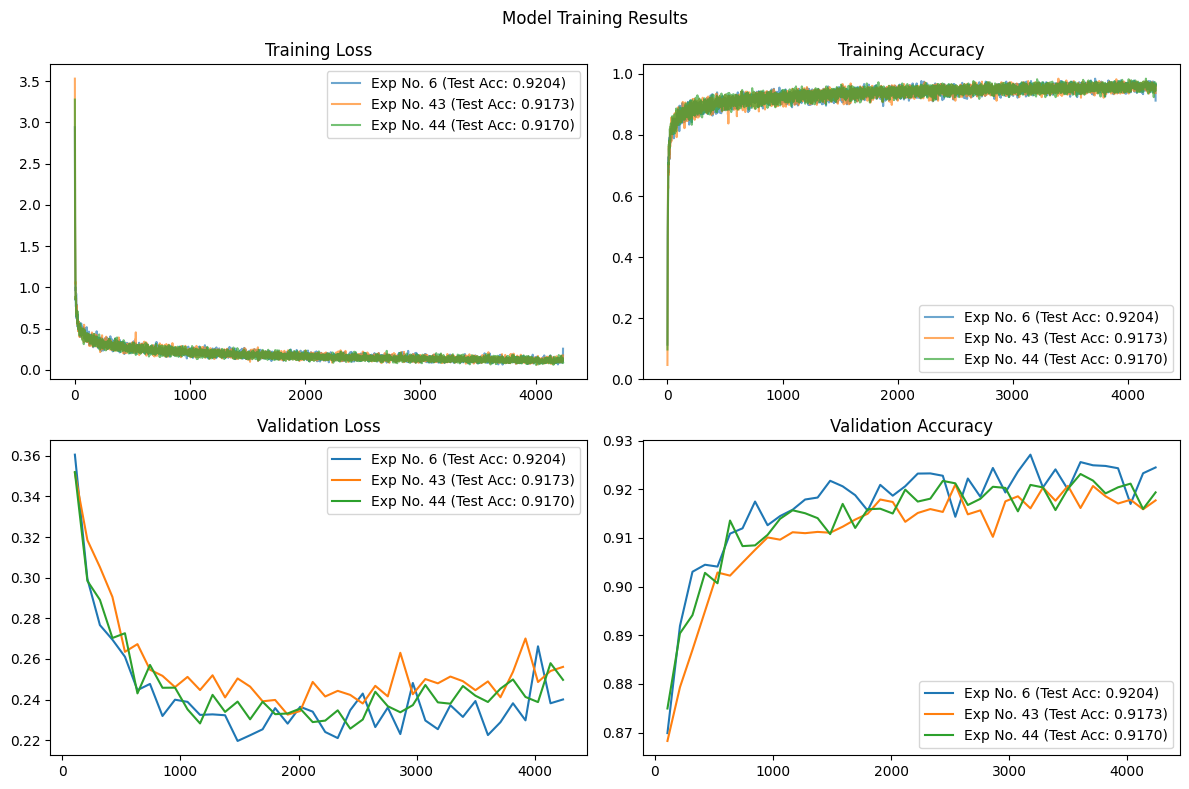

In [8]:
models, model_metadata_list = gather_metadata([6, 43, 44])

plot_model_results(
    model_metadata_list,
    [6, 43, 44],
    savefig=True,
)

In [ ]:
# TODO: Move the import later
from src.data_analysis.model_training import (
    get_device_helper,
    get_fashion_mnist_data_sets
)

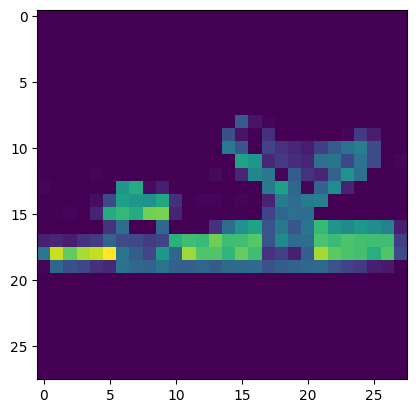

In [90]:
CMAP = 'BrBG_r'

train_dataset, test_dataset = get_fashion_mnist_data_sets()
device = get_device_helper()

plt.imshow(train_dataset.data[-1], cmap="viridis")
plt.show()

In [40]:
model_for_feature_map_viz = models[2]
model_for_feature_map_viz = model_for_feature_map_viz.to(device)
model_for_feature_map_viz.eval()

# TODO: Load the fashionmnist dataset
conv_layers = []
max_pool_layers = []
# TODO: Setup where to save the conv layers

for child in model_for_feature_map_viz.children():
    if isinstance(child, torch.nn.Sequential):
        for child_child in child.children():
            if isinstance(child_child, torch.nn.Conv2d):
                conv_layers.append(child_child)
            elif isinstance(child_child, torch.nn.MaxPool2d):
                max_pool_layers.append(child_child)
            else:
                continue
    else:
        continue


In [59]:
# TODO: move feature_map_image to the device and give it a batch and channel dim
feature_map_image = train_dataset.data[-1]
feature_map_image = feature_map_image.unsqueeze(0).unsqueeze(0).float()
feature_map_image_on_device = feature_map_image.to(device)

# TODO: Get the feature maps
feature_maps = []
input_image = feature_map_image_on_device
for layer in conv_layers:
    input_image = layer(input_image)
    feature_maps.append(input_image.squeeze(0).cpu().detach().numpy())

In [71]:
len(list(axs.flat))

16

In [92]:
feature_maps[0].shape[0]

16

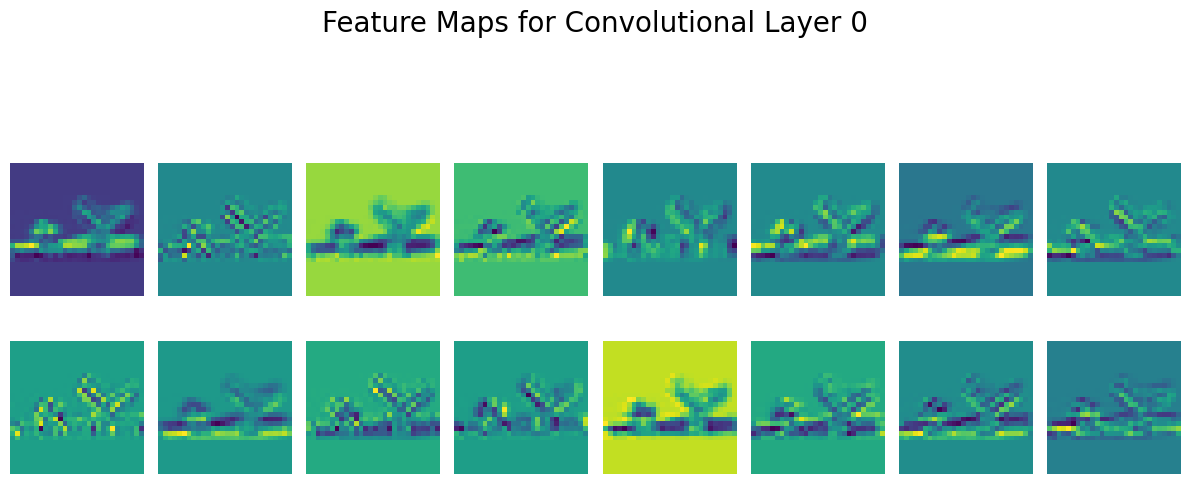

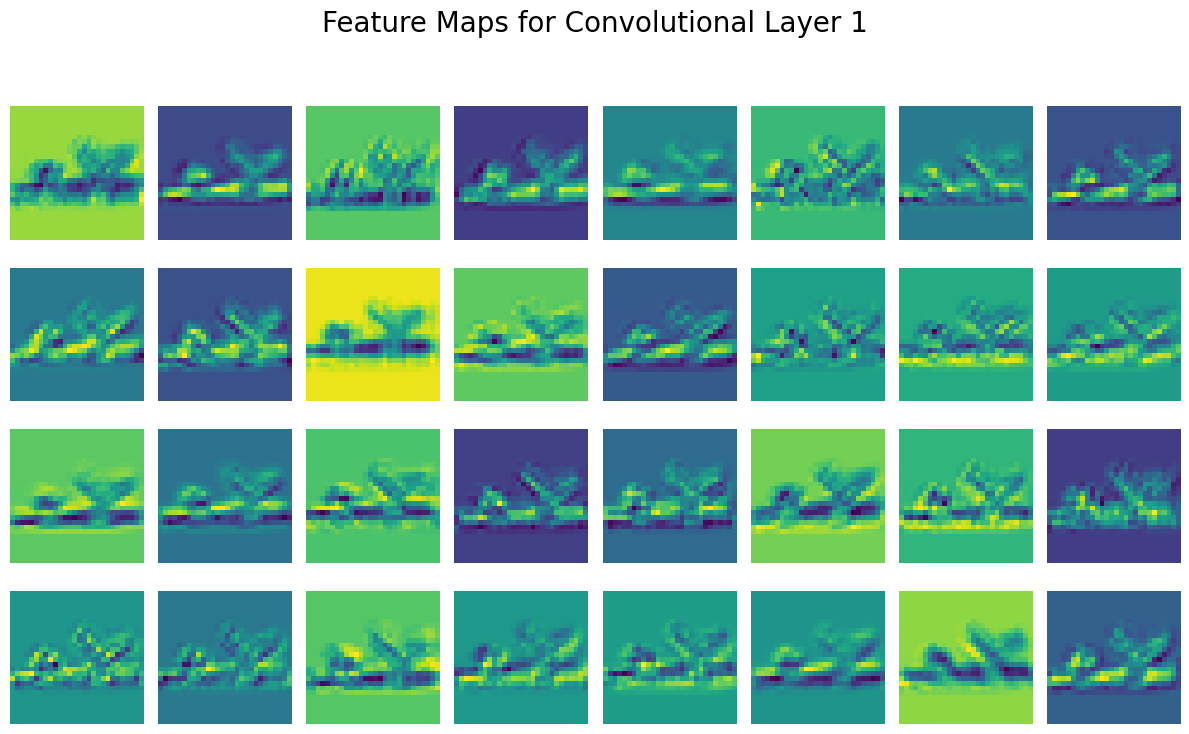

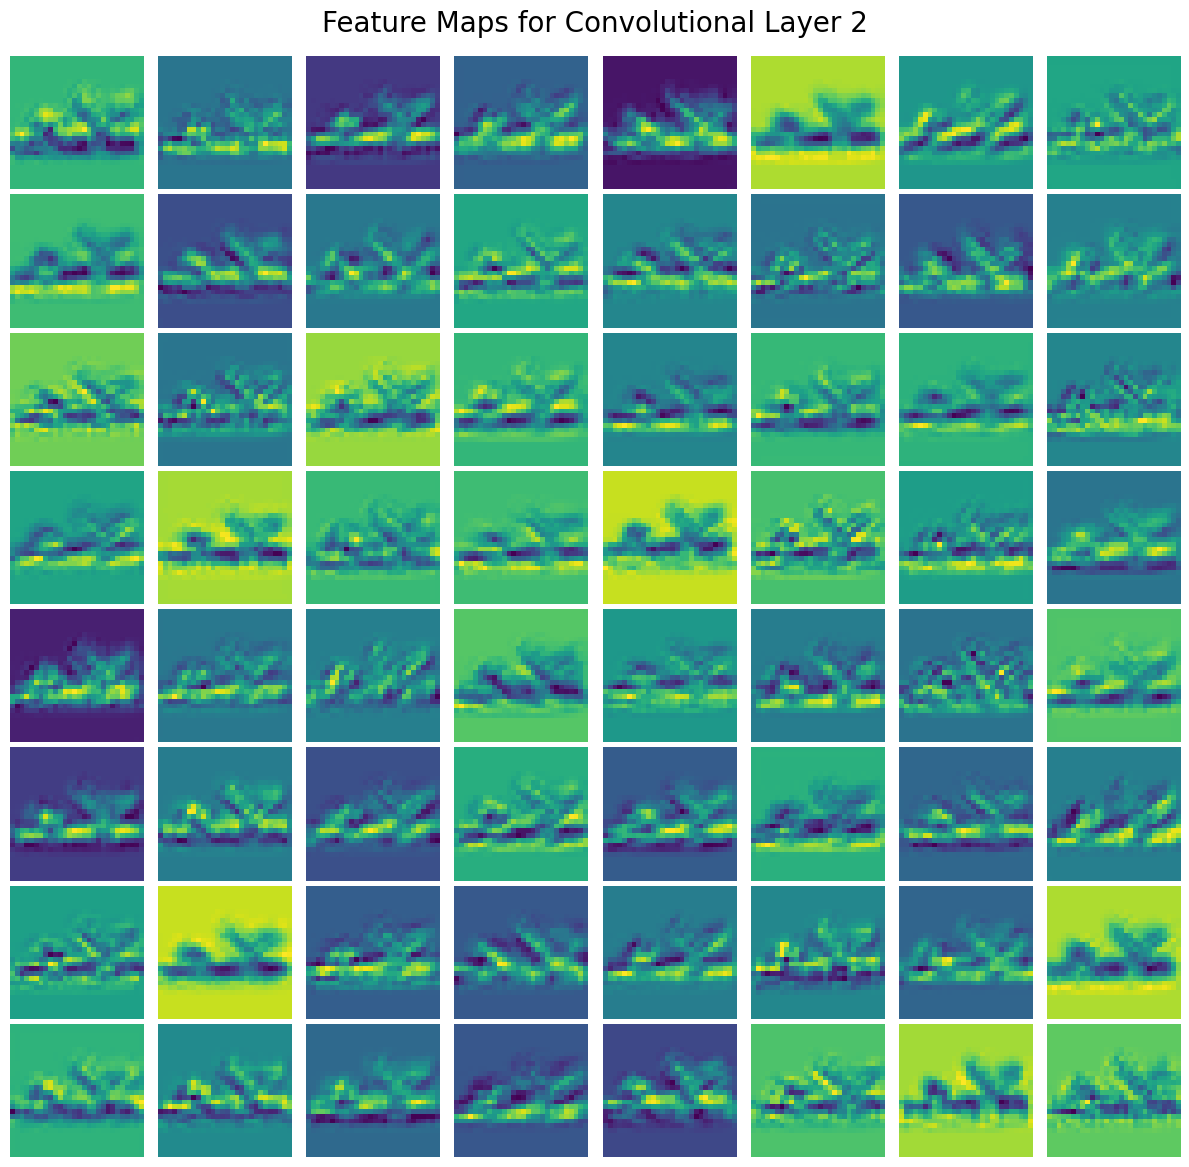

In [ ]:
for j, feature_map in enumerate(feature_maps):
    columns = 8 
    rows = feature_map.shape[0] // 8
    fig, axs = plt.subplots(rows, columns, figsize=(columns + 4, rows + 4), dpi=100)
    for i, ax in enumerate(axs.flat):
        ax.imshow(feature_map[i], cmap="viridis")
        ax.axis('off')
        plt.suptitle(f'Feature Maps for Convolutional Layer {j}', fontsize=20)
        plt.tight_layout()
    # plt.savefig(f'visualizations/feature_maps_conv_layer_{j}.png')
    plt.show()

In [54]:
def model_arch_filter(x: pd.DataFrame, desired_arch: list[int]) -> pd.Series:
    return x["model_architecture"] == desired_arch

experiment_results_df.apply(model_arch_filter, axis=1, args=([1024, 512, 10],))

no_batch_norm_rand_normal_mask = (
    experiment_results_df["batch_normalization"]
    & (experiment_results_df["weight_init"] == "xavier_uniform")
    & (experiment_results_df["optimizer"] == "Adam")
    # & (experiment_results_df["learning_rate"] == 0.01)
    & (experiment_results_df["num_epochs"] == 30)
    & experiment_results_df.apply(model_arch_filter, axis=1, args=([1024, 256, 10],))
)
no_batch_norm_rand_normal_mask.sum()

experiment_results_df[no_batch_norm_rand_normal_mask]

,num_epochs,mean_test_accuracy,std_test_accuracy,model_architecture,dropout_rate,activation_function,optimizer,learning_rate,optimizer_hyperparams,batch_normalization,weight_init
109,30,0.890625,0.021360,"[1024, 256, 10]","[0.1, 0.1]",relu,Adam,0.0100,"{'betas': [0.9, 0.9]}",True,xavier_uniform
111,30,0.896680,0.022217,"[1024, 256, 10]","[0.3, 0.5]",relu,Adam,0.0010,"{'betas': [0.95, 0.9]}",True,xavier_uniform
113,30,0.893262,0.018924,"[1024, 256, 10]","[0.5, 0.2]",relu,Adam,0.0001,"{'betas': [0.95, 0.9]}",True,xavier_uniform


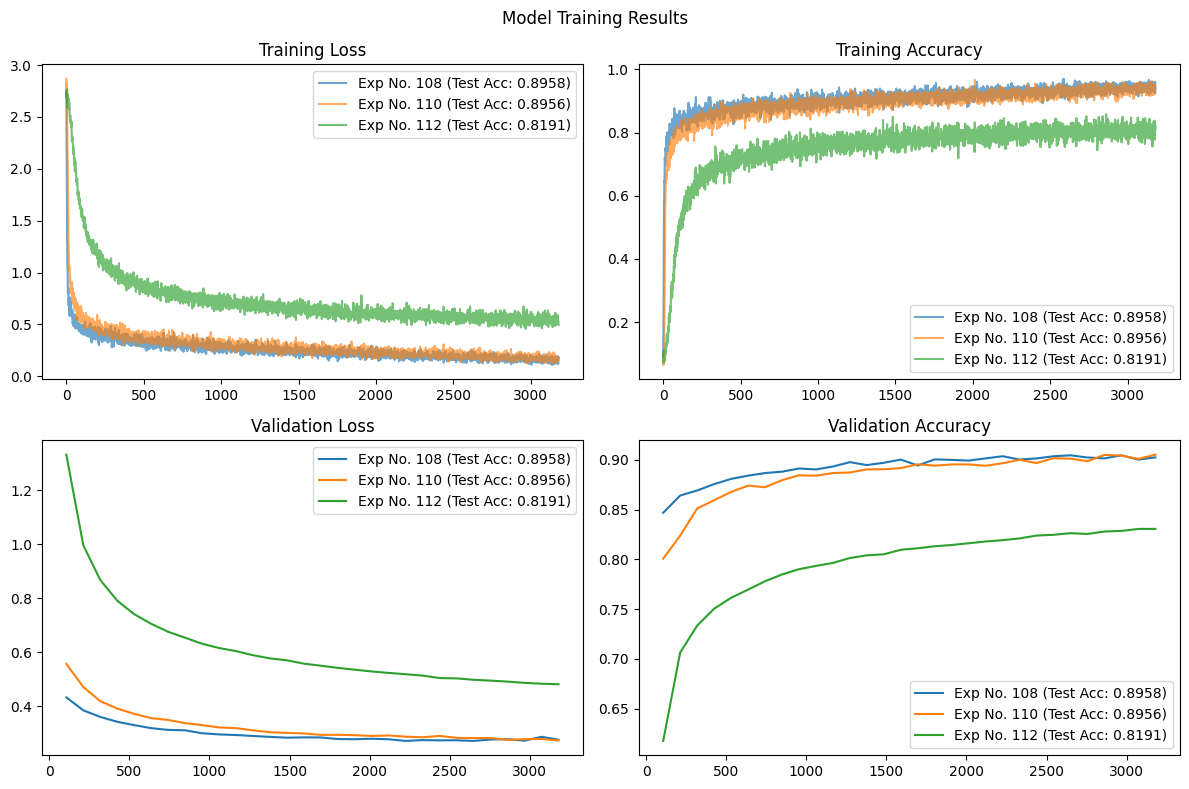

In [53]:
exps = experiment_results_df[no_batch_norm_rand_normal_mask].index.tolist()
model_metadata_list = gather_metadata(
    exps
)

plot_model_results(
    model_metadata_list,
    exps,
    savefig=True,
)

In [14]:
experiment_subset_mask = (
    (experiment_results_df["num_epochs"] == 30) &
    (experiment_results_df["batch_normalization"] == True) &
    (experiment_results_df["model_architecture"].apply(lambda x: tuple(x)) == (1024, 256, 10)) &
    (experiment_results_df["optimizer"] == "Adam")
)

experiment_results_df[experiment_subset_mask]

,num_epochs,mean_test_accuracy,std_test_accuracy,model_architecture,dropout_rate,activation_function,optimizer,learning_rate,optimizer_hyperparams,batch_normalization,weight_init
109,30,0.890625,0.021360,"[1024, 256, 10]","[0.1, 0.1]",relu,Adam,0.0100,"{'betas': [0.9, 0.9]}",True,xavier_uniform
111,30,0.896680,0.022217,"[1024, 256, 10]","[0.3, 0.5]",relu,Adam,0.0010,"{'betas': [0.95, 0.9]}",True,xavier_uniform
113,30,0.893262,0.018924,"[1024, 256, 10]","[0.5, 0.2]",relu,Adam,0.0001,"{'betas': [0.95, 0.9]}",True,xavier_uniform
121,30,0.890332,0.016788,"[1024, 256, 10]","[0.2, 0.1]",relu,Adam,0.0100,"{'betas': [0.9, 0.95]}",True,random_normal
123,30,0.880762,0.020222,"[1024, 256, 10]","[0.3, 0.2]",relu,Adam,0.0010,"{'betas': [0.9, 0.99]}",True,random_normal
125,30,0.842383,0.030100,"[1024, 256, 10]","[0.3, 0.2]",relu,Adam,0.0001,"{'betas': [0.95, 0.99]}",True,random_normal
133,30,0.102148,0.018786,"[1024, 256, 10]","[0.5, 0.5]",relu,Adam,0.0100,"{'betas': [0.99, 0.9]}",True,kaiming_uniform
135,30,0.891211,0.017568,"[1024, 256, 10]","[0.1, 0.1]",relu,Adam,0.0010,"{'betas': [0.99, 0.95]}",True,kaiming_uniform
137,30,0.898828,0.017595,"[1024, 256, 10]","[0.2, 0.2]",relu,Adam,0.0001,"{'betas': [0.9, 0.9]}",True,kaiming_uniform


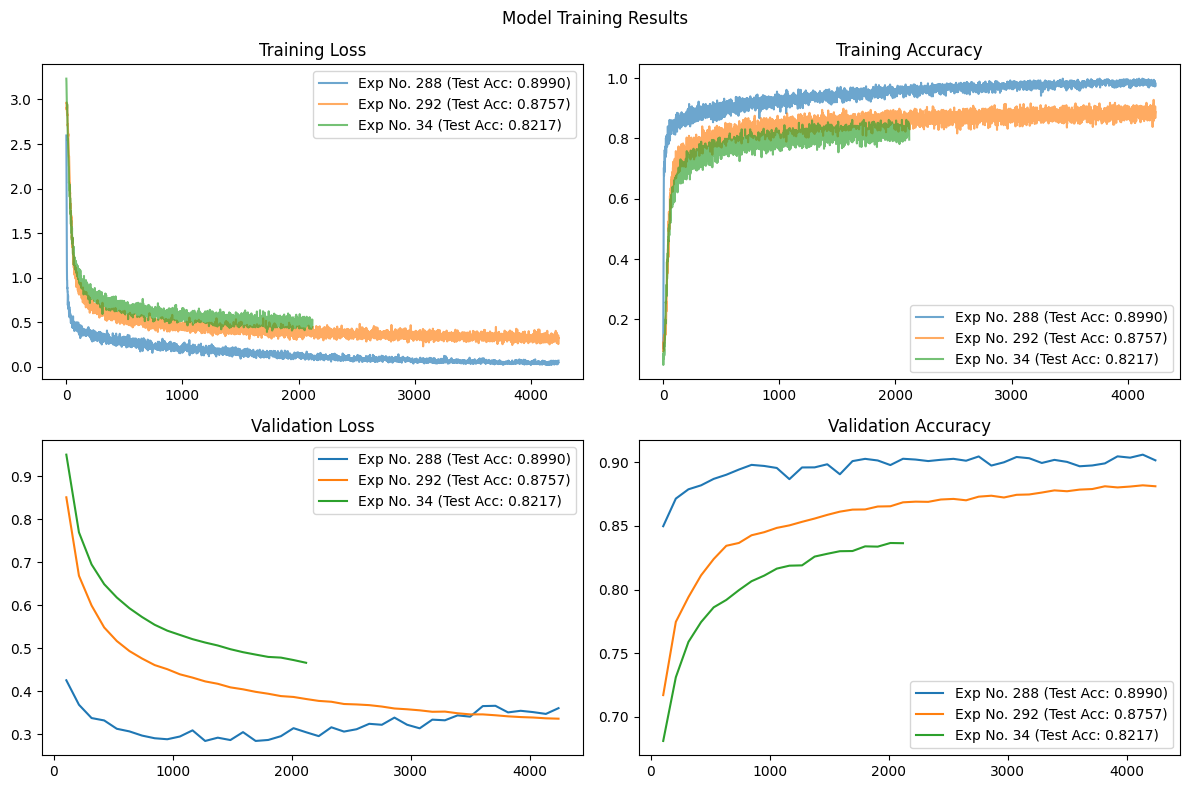

In [19]:
# experiments = experiment_results_df[np.random.randint(0, experiment_results_df.shape[0], 5).tolist()].index
experiments = np.random.randint(0, experiment_results_df.shape[0], 3).tolist()
model_metadata_list = gather_metadata(experiments)

plot_model_results(model_metadata_list, experiments, savefig=False)